<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: Лисицын Сергей
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 9. Разреженные данные, онлайн-обучение</center>

## <center>Часть 4. Функции потерь</center>

Vowpal Wabbit, фактически, является общей системой для обучения и реализует целый ряд алгоритмов классификации и регрессии. Основным выбором, стоящим перед пользователем VW является выбор функции потерь $\ell(y, p)$, измеряющей ошибку между текущим предсказанием и известным ответом. В этой части занятия мы рассмотрим две функции потерь для задач регрессии и две функции потерь для задач классификации.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use('ggplot')

### <center>Квадратичная функция потерь</center>

Квадратичная функция потерь является стандартным выбором для задач регрессии и имеет вид:
$$\ell (y, p) = \frac{1}{2}(p-y)^2$$

Нетрудно показать, что такая функция возникает естественным образом из модели с аддитивным независимым гауссовским шумом. Минимизатором такой ошибки является средний прогноз, поэтому можно считать, что регрессор, обученный на задаче регрессии цен на недвижимость с такой функцией потерь будет предсказывать среднюю цену объекта в зависимости от его характеристик.

Предположим, что мы ожидаем правильный ответ y=0.3, график функции потерь в зависимости от предсказания тогда имеет вид:

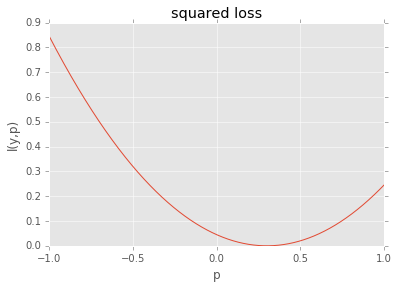

In [2]:
ps = np.arange(-1.0, 1.0, 1e-3)
y = 0.3
plt.plot(ps, 0.5*(ps - y)**2)
plt.xlabel('p'); plt.ylabel('l(y,p)'); plt.title('squared loss');

Из графика и непосредственно формулы легко заметить, что такая функция штрафует за отклонения от правильного ответа существенно сильнее, если это отклонение растет. На практике это может привести к чувствительности к выбросам в данных.

Для того, чтобы использовать такую функцию потерь в vw, необходимо указать аргумент loss_function со значением squared:

In [3]:
! echo | vw --loss_function squared

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  unknown   0.0000        1

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1.000000
weighted label sum = 0.000000
average loss = 0.000000
total feature number = 1


### <center>Квантильная функция потерь</center>

Также, как и квадратичная, квантильная функция потерь подходит для задач регрессии и имеет вид:
$$\ell (y, p) = \tau (y-p) [y \geq p] + (1-\tau) (p-y) [y \leq p]$$

В отличие от квадратичной функции потерь, минимизатором такой функции является соответствующий $\tau$-квантиль. К примеру, в случае $\tau = 0.5$ может быть получена модель, предсказывающая медианную цену товара с учетом его параметров.

Для фиксированного tau = 0.5 и y = 0.3 график такой функции будет иметь вид:

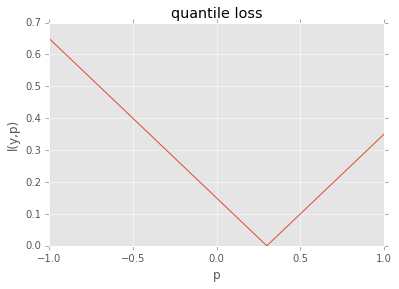

In [4]:
tau = 0.5
y = 0.3

def quantile_loss(p):
    if y >= p:
        return tau*(y-p)
    else:
        return (1.0-tau)*(p-y)

ps = np.arange(-1.0, 1.0, 1e-3)
plt.plot(ps, map(quantile_loss, ps))
plt.xlabel('p'); plt.ylabel('l(y,p)'); plt.title('quantile loss');

Чтобы использовать квантильную функцию потерь в vw нужно задать loss_function равным quantile. Параметр $\tau$ может быть задан через quantile_tau:

In [5]:
! echo | vw --loss_function quantile --quantile_tau 0.5

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  unknown   0.0000        1

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1.000000
weighted label sum = 0.000000
average loss = 0.000000
total feature number = 1


###  <center>Логистическая функция потерь</center>

Логистическая функция потерь подходит для задач бинарной классификации, в которых важную роль играет предсказание вероятности:
$$
\ell (y,p) = \log (1 + \exp(-yp))
$$

Примером такой задачи может являться прогнозирование клика по баннеру в интернете - задача важная для многих интернет-компаний. Вероятность в таком случае используется в частности для определение ставки в аукционе, происходящем перед каждым показом рекламы.

График функции потерь в зависимости от предсказания имеет следующий вид:

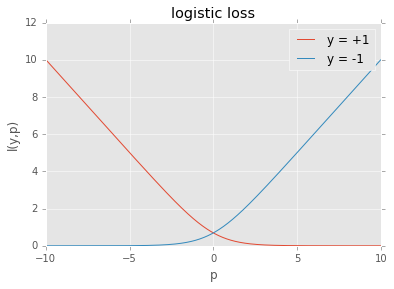

In [14]:
ps = np.arange(-10.0, 10.0, 0.01)

def logloss(p, y):
    return np.log(1.0 + np.exp(-y*p))

plt.plot(ps, map(lambda p: logloss(p, +1), ps), label='y = +1')
plt.plot(ps, map(lambda p: logloss(p, -1), ps), label='y = -1')
plt.legend(); plt.xlabel('p'); plt.ylabel('l(y,p)'); plt.title('logistic loss');

Для того, чтобы использовать логистическую функцию потерь в vw, необходимо задать параметр loss_function в значение logistic. Для того, чтобы использовать логистическое преобразование ответов в интервал [0,1], нужно задать link в значение logistic

In [9]:
! echo | vw --loss_function logistic --link logistic

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  unknown   0.5000        1

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1.000000
weighted label sum = 0.000000
average loss = 0.000000
total feature number = 1


### <center>Пороговая (hinge) функция потерь</center>

Пороговая функция подходит для тех задач, где дискриминативная способность алгоритма классификации важнее, чем точное предсказание вероятности, как при использовании логистической функции потерь. Функция имеет вид:

$$
\ell(y,p) = \max(0, 1-yp)
$$

В данном случае $y$ может принимать значения $+1$ и $-1$, тогда график функции потерь имеет вид: 

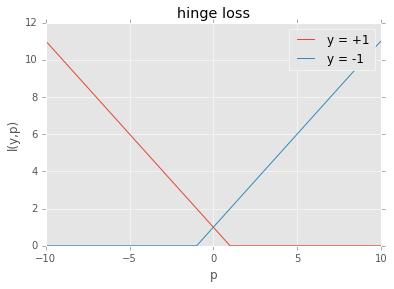

In [10]:
ps = np.arange(-10.0, 10.0, 0.01)

def hinge(p, y):
    return max(0, 1.0-y*p)

plt.plot(ps, map(lambda p: hinge(p, +1), ps), label='y = +1')
plt.plot(ps, map(lambda p: hinge(p, -1), ps), label='y = -1')
plt.legend(); plt.xlabel('p'); plt.ylabel('l(y,p)'); plt.title('hinge loss');

Пороговая функция штрафует алгоритм за неверную классификацию объектов линейно 

Для того, чтобы использовать hinge loss в vw надо задать loss_function в значение hinge:

In [11]:
! echo | vw --loss_function hinge

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  unknown   0.0000        1

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1.000000
weighted label sum = 0.000000
average loss = 0.000000
total feature number = 1


### Ссылки

- https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions